In [23]:
import torch
import torch.nn as nn
import csv
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
# 从CSV文件加载数据
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)  # 跳过文件头部
        for line in reader:
            sentence, label = line
            data.append((sentence, int(label == 'negative')))
    return data

In [26]:
# 数据集类
class IMDbDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.tokenizer = tokenizer
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence, label = self.data[idx]
        encoding = self.tokenizer.encode_plus(
            sentence,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return input_ids, attention_mask, label

In [27]:
# 定义自定义模型
class RoBERTaClassifier(nn.Module):
    def __init__(self, num_classes):
        super(RoBERTaClassifier, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.neck = nn.Linear(self.roberta.config.hidden_size, 256)
        self.tail = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        features = self.neck(pooled_output)
        logits = self.tail(features)
        return logits

In [32]:
# 加载数据集并进行分割
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
data = load_data('IMDB-LT.csv')
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [33]:
# 创建训练集和验证集
train_dataset = IMDbDataset(train_data, tokenizer)
val_dataset = IMDbDataset(val_data, tokenizer)

In [41]:
# 定义超参数
batch_size = 32
num_classes = 2
num_epochs = 100

In [42]:
# 创建数据加载器
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [43]:
# 构建模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RoBERTaClassifier(num_classes).to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
# 定义损失函数
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, input, target):
        log_probs = torch.nn.functional.log_softmax(input, dim=-1)
        probs = torch.exp(log_probs)
        loss = -torch.pow(1 - probs, self.gamma) * log_probs
        return loss.mean()

criterion = FocalLoss(gamma=2)

In [45]:
# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [46]:
# 训练模型
best_val_loss = float('inf')
no_improve_epoch = 0
max_no_improve_epoch = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 计算准确度
        predictions = torch.argmax(logits, dim=1)
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    average_loss = total_loss / len(train_dataloader)
    accuracy = total_correct / total_samples
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')
    
    # 验证步骤
    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_samples = 0
    all_val_labels = []
    all_val_predictions = []

    with torch.no_grad():
        for val_batch in val_dataloader:
            val_input_ids, val_attention_mask, val_labels = val_batch
            val_input_ids = val_input_ids.to(device)
            val_attention_mask = val_attention_mask.to(device)
            val_labels = val_labels.to(device)

            val_logits = model(val_input_ids, val_attention_mask)
            val_loss = criterion(val_logits, val_labels)

            total_val_loss += val_loss.item()

            # 计算验证集的准确度
            val_predictions = torch.argmax(val_logits, dim=1)
            total_val_correct += (val_predictions == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
            all_val_predictions.extend(val_predictions.cpu().numpy())
            all_val_labels.extend(val_labels.cpu().numpy())

    average_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = total_val_correct / total_val_samples
    print(f'Val Loss: {average_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # 如果验证损失没有改进，增加无改进的轮数
    if average_val_loss >= best_val_loss:
        no_improve_epoch += 1
    else: # 否则，保存最好的模型，并重置无改进的轮数
        torch.save(model.state_dict(), 'best_model.pth')
        best_val_loss = average_val_loss
        no_improve_epoch = 0

    # 如果无改进的轮数达到最大值，提前结束训练
    if no_improve_epoch >= max_no_improve_epoch:
        print(f"Validation loss has not improved for {no_improve_epoch} epochs, stopping early.")
        break

Epoch 1/100, Loss: 0.1746, Accuracy: 0.4720
Val Loss: 0.1736, Val Accuracy: 0.0244
Epoch 2/100, Loss: 0.1738, Accuracy: 0.3354
Val Loss: 0.1733, Val Accuracy: 0.5610
Epoch 3/100, Loss: 0.1738, Accuracy: 0.3789
Val Loss: 0.1734, Val Accuracy: 0.0244
Epoch 4/100, Loss: 0.1737, Accuracy: 0.2484
Val Loss: 0.1734, Val Accuracy: 0.9756
Epoch 5/100, Loss: 0.1741, Accuracy: 0.6584
Val Loss: 0.1737, Val Accuracy: 0.0244
Epoch 6/100, Loss: 0.1738, Accuracy: 0.1739
Val Loss: 0.1735, Val Accuracy: 0.9756
Epoch 7/100, Loss: 0.1738, Accuracy: 0.6957
Val Loss: 0.1733, Val Accuracy: 0.0732
Epoch 8/100, Loss: 0.1736, Accuracy: 0.3913
Val Loss: 0.1733, Val Accuracy: 0.9756
Epoch 9/100, Loss: 0.1736, Accuracy: 0.6025
Val Loss: 0.1733, Val Accuracy: 0.3902
Epoch 10/100, Loss: 0.1735, Accuracy: 0.4845
Val Loss: 0.1733, Val Accuracy: 0.7805
Epoch 11/100, Loss: 0.1736, Accuracy: 0.4472
Val Loss: 0.1733, Val Accuracy: 0.9756
Epoch 12/100, Loss: 0.1735, Accuracy: 0.6894
Val Loss: 0.1733, Val Accuracy: 0.4390
E

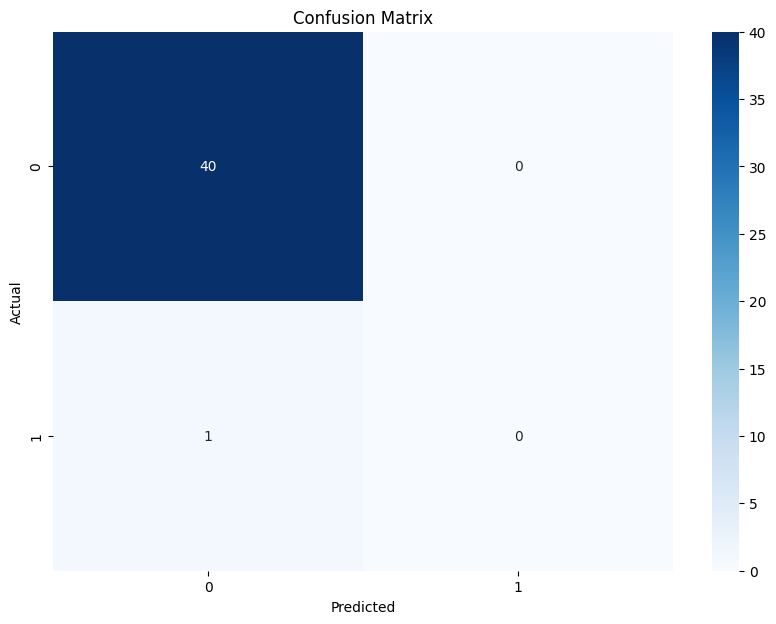

In [22]:
# 生成混淆矩阵
cm = confusion_matrix(all_val_labels, all_val_predictions)

# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()